In [62]:
import pandas as pd
import geopandas as gpd

# === 1. Excel-Datei einlesen ===
excel_path = "Biggest_Cities_Bavaria.xlsx"
df = pd.read_excel(excel_path, dtype=str)  # alle Spalten als Strings laden

# Spaltennamen säubern und sicherstellen, dass relevante Felder korrekt benannt sind
df.columns = df.columns.str.strip()
df = df.rename(columns={
    "ARS": "ARS",
    "Name": "Name",
    "Einwohner": "Einwohner"
})

# Einwohner in Integer umwandeln
df["Einwohner"] = df["Einwohner"].astype(int)

# Top 50 Städte nach Einwohnerzahl auswählen
df = df.sort_values(by="Einwohner", ascending=False).head(50)

# === 2. ARS-Spalte normalisieren ===
# Ziel: 8-stellig mit führender Null + 4 Nullen → 12-stellig wie in Shapefile
df["ARS"] = df["ARS"].str.zfill(8) + "0000"

# Falls versehentlich zu lang: auf 12 Stellen kürzen
df["ARS"] = df["ARS"].str[:12]

# === 3. Shapefile einlesen und Bayern filtern ===
shapefile_path = "Input/VG250_GEM.shp"
gdf = gpd.read_file(shapefile_path)

# ARS als String behandeln und auf 12 Stellen beschränken
gdf["ARS"] = gdf["ARS"].astype(str).str.strip()
gdf_bayern = gdf[gdf["ARS"].str.startswith("09")]

# === 4. Merge durchführen ===
merged = gdf_bayern.merge(df, on="ARS")

print(f"✅ {len(merged)} von 50 Städte erfolgreich gemerged.")

# === 5. Neue Shapefile exportieren ===
output_path = "input/top50_bayern_staedte.shp"
merged.to_file(output_path)

print("🎉 Shapefile erfolgreich gespeichert unter:", output_path)


✅ 50 von 50 Städte erfolgreich gemerged.
🎉 Shapefile erfolgreich gespeichert unter: input/top50_bayern_staedte.shp


/Users/johnfriesen/Documents/GitHub/Temperature_Comparison/myenv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field BEGINN create as date field, though DateTime requested.
  ogr_write(
/Users/johnfriesen/Documents/GitHub/Temperature_Comparison/myenv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Field WSK create as date field, though DateTime requested.
  ogr_write(
/Users/johnfriesen/Documents/GitHub/Temperature_Comparison/myenv/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Unnamed: 2' to 'Unnamed_ 2'
  ogr_write(


In [2]:
import pandas as pd
from pathlib import Path

# -------------------------------------------------------------------------
# 1.  LOAD  –– choose ONE of the two options
# -------------------------------------------------------------------------
# (a) from disk …
df = pd.read_csv(Path("Input/city_metrics.csv"))

# (b) … or, if your CSV is already in a Python string variable `raw`:
# from io import StringIO
# df = pd.read_csv(StringIO(raw))

# -------------------------------------------------------------------------
# 2.  HOUSE-KEEPING
# -------------------------------------------------------------------------
df["sensor"] = df["sensor"].str.strip().str.upper()        # e.g. 'LANDSAT_8' → 'LANDSAT_8'
df["date"]   = pd.to_datetime(df["date"]).dt.normalize()   # strips any time component

# split the frame once so we preserve all original columns for later inspection
modis    = df[df["sensor"].str.contains(r"\bMODIS\b",    regex=True)].copy()
landsat  = df[df["sensor"].str.contains(r"\bLANDSAT\b",  regex=True)].copy()

# keep ONLY the date column in the two 'key' frames we will merge on
modis_key   = modis[["date"]].rename(columns={"date": "modis_date"}).drop_duplicates()
landsat_key = landsat[["date"]].rename(columns={"date": "landsat_date"}).drop_duplicates()

# -------------------------------------------------------------------------
# 3.  CROSS-JOIN + FILTER BY ≤ 3 DAYS
# -------------------------------------------------------------------------
# create a dummy 'key' so pandas gives us the Cartesian product
modis_key["k"]   = 1
landsat_key["k"] = 1

pairs = (modis_key
         .merge(landsat_key, on="k", how="inner")
         .drop("k", axis=1))

pairs["diff_days"] = (pairs["modis_date"] - pairs["landsat_date"]).abs().dt.days
close_pairs = pairs.query("diff_days <= 2").sort_values(["modis_date", "diff_days"])

# -------------------------------------------------------------------------
# 4.  DISPLAY / SAVE / USE THE RESULT
# -------------------------------------------------------------------------
if close_pairs.empty:
    print("⚠️  No Landsat/MODIS observations lie within ±3 days of each other.")
else:
    print("Landsat vs. MODIS dates that are ≤ 3 days apart:")
    print(close_pairs.to_string(index=False))

    # (optional) keep the FULL rows for those dates:
    overlap_dates = pd.unique(close_pairs[["modis_date", "landsat_date"]].values.ravel("K"))
    df_3day_window = df[df["date"].isin(overlap_dates)]

    # df_3day_window now holds every original record that participates in at
    # least one ≤ 3-day Landsat/MODIS pairing – handy for plotting or export.


Landsat vs. MODIS dates that are ≤ 3 days apart:
modis_date landsat_date  diff_days
2024-01-09   2024-01-11          2
2024-01-25   2024-01-27          2
2024-02-26   2024-02-28          2
2024-03-29   2024-03-31          2
2024-04-30   2024-05-02          2
2024-08-04   2024-08-06          2
2024-09-05   2024-09-07          2



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/4255233235.py:6: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/4255233235.py:6: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/4255233235.py:6: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14

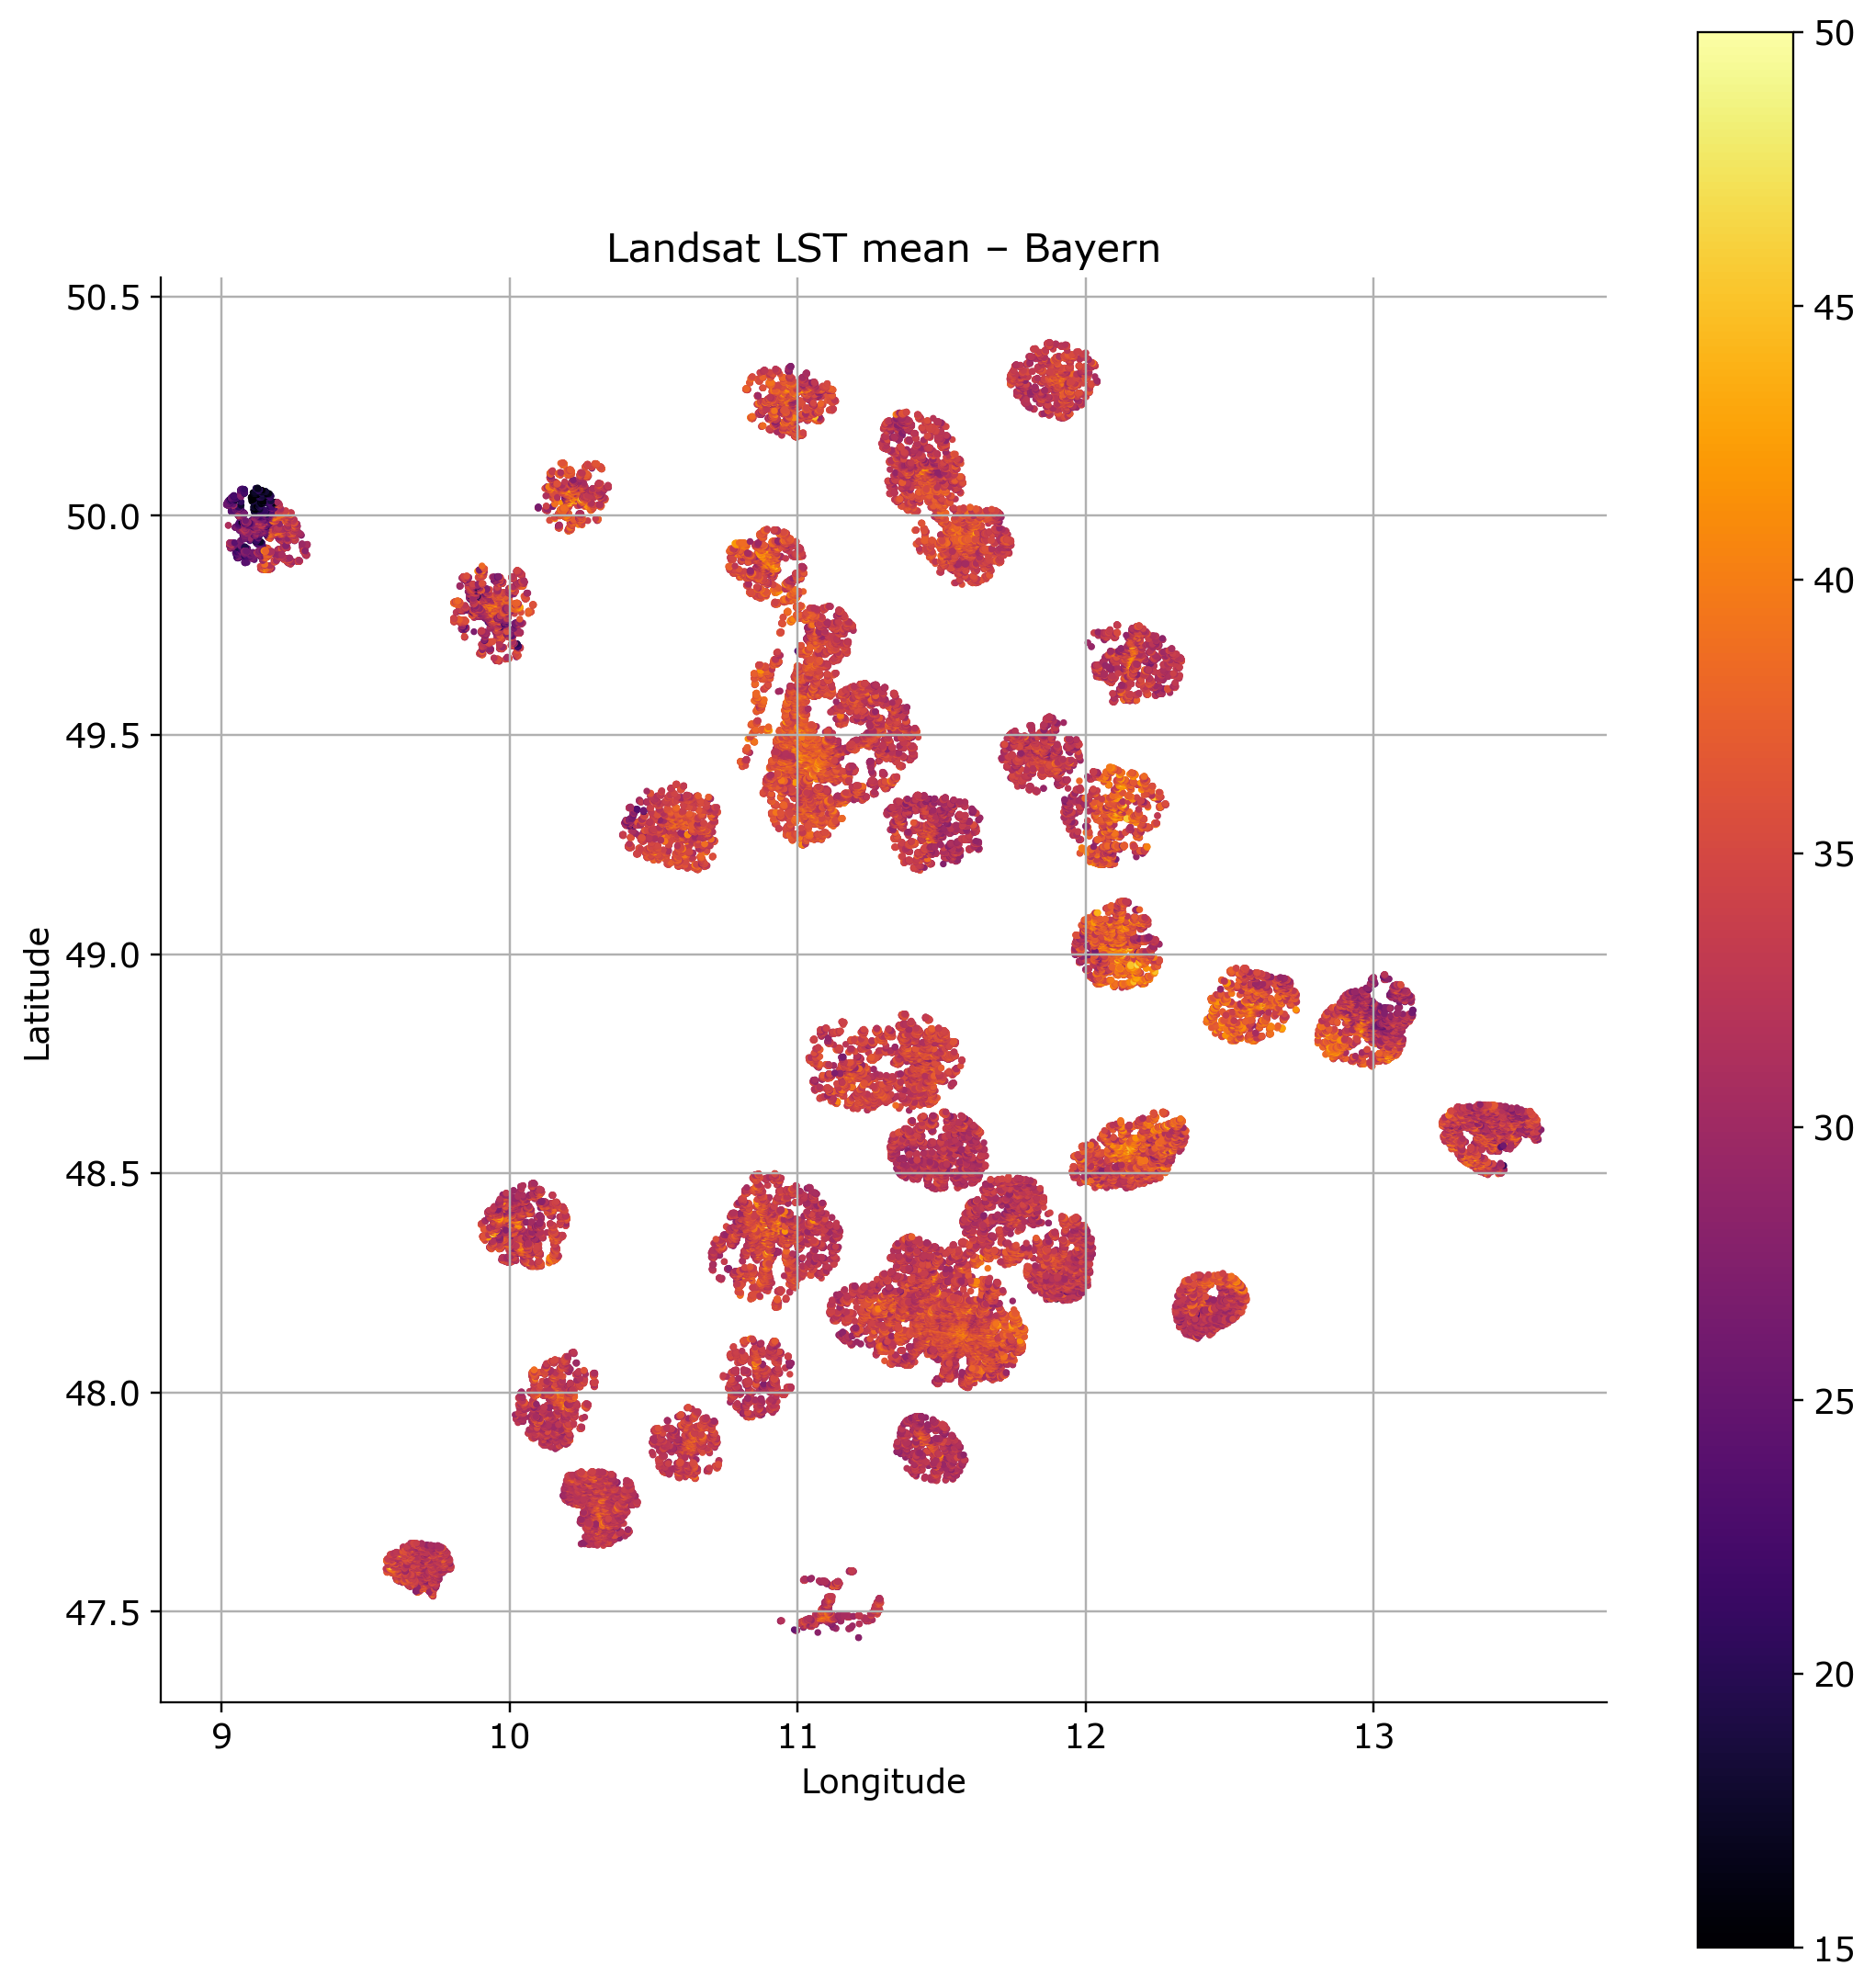

In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

plt.style.use("FST.mplstyle")


# === 1. CSV laden ===
csv_path = "LST_NDVI_Landcover_Landsat_Bayern.csv"
df = pd.read_csv(csv_path)

# === 2. Nur gültige Koordinaten behalten ===
df = df.dropna(subset=["Latitude", "Longitude"])
df["Latitude"] = df["Latitude"].astype(float)
df["Longitude"] = df["Longitude"].astype(float)

# === 3. GeoDataFrame erzeugen ===
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
    crs="EPSG:4326"  # WGS84
)

# === 4. Plotten (z. B. nach LST_day_Mean einfärben) ===
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column="LST_Max",
    cmap="inferno",
    vmin=15,               # Untere Grenze der Farbskala
    vmax=50,          # Wärmeskala
    legend=True,
    ax=ax,
    markersize=2,
    missing_kwds={"color": "lightgrey", "label": "Kein Wert"}
)

plt.title("Landsat LST mean – Bayern", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()



In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("FST.mplstyle")

# === 1. Daten einlesen ===
stations_df = pd.read_csv("Input/city_metrics.csv")
pixels_df = pd.read_csv("LST_NDVI_Landcover_Landsat_Bayern.csv")

# === 2. Nur MODIS + Sommerdaten verwenden ===
stations_df = stations_df[
    (stations_df["season"] == "Summer") &
    (stations_df["sensor"] == "Landsat")
]

# === 3. Ausgabeordner für Plots anlegen ===
output_dir = "plots_by_city"
os.makedirs(output_dir, exist_ok=True)

# === 4. Städte aus Pixel-Daten verwenden (besserer Referenzpunkt) ===
unique_cities = pixels_df["City"].dropna().unique()

# === 5. Schleife über alle Städte ===
for stadt in unique_cities:
    # Stationsdaten mit passendem Stadtnamen (Teilstring-Suche)
    station_data = stations_df[stations_df["Name"].str.contains(stadt, case=False, na=False)]
    stadt_pixel_data = pixels_df[pixels_df["City"].str.contains(stadt, case=False, na=False)]

    # Falls keine Daten vorhanden, überspringen
    if station_data.empty or stadt_pixel_data.empty:
        print(f"⚠️ Überspringe {stadt} – keine passenden Daten gefunden")
        continue

    # === 6. Stationsstatistiken berechnen ===
    station_stats = {
        "TXK_mean": station_data["TXK"].mean(),
        "LST_Max": station_data["LST"].max(),
        "LST_Mean": station_data["LST"].mean()
    }

    print(f"\n📍 Stadt: {stadt}")
    for k, v in station_stats.items():
        print(f"  {k}: {v:.2f} °C")

    # === 7. Boxplots erstellen ===
    plt.figure(figsize=(12, 5))
    vars_to_plot = ["LST_Max", "LST_Mean"]

    for i, var in enumerate(vars_to_plot):
        plt.subplot(1, 2, i + 1)

        sns.boxplot(y=stadt_pixel_data[var])

        # MODIS-Wert (rot)
        plt.scatter(0, station_stats[var], color='red', zorder=10, label='Landsat (Wetterstation)')

        # TXK-Wert (blau)
        plt.scatter(0, station_stats["TXK_mean"], color='blue', zorder=11, label='TXK (Wetterstation)')

        plt.title(f"{stadt} – {var}")
        plt.ylabel("°C")
        plt.xticks([])
        if i == 0:
            plt.legend()

    plt.suptitle(f"{stadt}: LST-Verteilung vs. Wetterstation (Sommer, Landsat & TXK)", fontsize=13)
    plt.tight_layout()

    # Plot speichern
    filename = f"{stadt.replace(' ', '_')}_Landsat_vergleich.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=150)
    plt.close()



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:6: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:6: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:6: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14

⚠️ Überspringe Fürstenfeldbruck – keine passenden Daten gefunden
⚠️ Überspringe Erding – keine passenden Daten gefunden
⚠️ Überspringe Germering – keine passenden Daten gefunden
⚠️ Überspringe Fürth – keine passenden Daten gefunden
⚠️ Überspringe Waldkraiburg – keine passenden Daten gefunden

📍 Stadt: Kaufbeuren
  TXK_mean: 24.55 °C
  LST_Max: 31.13 °C
  LST_Mean: 25.63 °C


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  station_data = stations_df[stations_df["Name"].str.contains(stadt, case=False, na=False)]
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  stadt_pixel_data = pixels_df[pixels_df["City"].str.contains(stadt, case=False, na=False)]


⚠️ Überspringe Lindau (Bodensee) – keine passenden Daten gefunden
⚠️ Überspringe Ansbach – keine passenden Daten gefunden

📍 Stadt: Regensburg
  TXK_mean: 31.45 °C
  LST_Max: 35.52 °C
  LST_Mean: 33.37 °C

📍 Stadt: Hof
  TXK_mean: 26.11 °C
  LST_Max: 36.82 °C
  LST_Mean: 32.09 °C

📍 Stadt: Bamberg
  TXK_mean: 31.45 °C
  LST_Max: 37.58 °C
  LST_Mean: 35.36 °C
⚠️ Überspringe Garmisch-Partenkirchen – keine passenden Daten gefunden
⚠️ Überspringe Deggendorf – keine passenden Daten gefunden
⚠️ Überspringe Weiden i.d. OPf. – keine passenden Daten gefunden
⚠️ Überspringe Pfaffenhofen a.d. Ilm – keine passenden Daten gefunden

📍 Stadt: Landshut
  TXK_mean: 28.50 °C
  LST_Max: 34.90 °C
  LST_Mean: 30.74 °C
⚠️ Überspringe Unterschleißheim – keine passenden Daten gefunden

📍 Stadt: Würzburg
  TXK_mean: 29.43 °C
  LST_Max: 33.53 °C
  LST_Mean: 27.57 °C
⚠️ Überspringe Lauf a.d. Pegnitz – keine passenden Daten gefunden

📍 Stadt: Augsburg
  TXK_mean: 26.45 °C
  LST_Max: 32.21 °C
  LST_Mean: 29.01 °C


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  station_data = stations_df[stations_df["Name"].str.contains(stadt, case=False, na=False)]
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_6782/2411430639.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  stadt_pixel_data = pixels_df[pixels_df["City"].str.contains(stadt, case=False, na=False)]



📍 Stadt: Schwandorf
  TXK_mean: 31.60 °C
  LST_Max: 40.22 °C
  LST_Mean: 38.08 °C
⚠️ Überspringe Kulmbach – keine passenden Daten gefunden
⚠️ Überspringe Ingolstadt – keine passenden Daten gefunden
⚠️ Überspringe Neuburg a.d. Donau – keine passenden Daten gefunden
⚠️ Überspringe Geretsried – keine passenden Daten gefunden
⚠️ Überspringe Passau – keine passenden Daten gefunden
⚠️ Überspringe Landsberg am Lech – keine passenden Daten gefunden
⚠️ Überspringe Erlangen – keine passenden Daten gefunden
⚠️ Überspringe Aschaffenburg – keine passenden Daten gefunden
⚠️ Überspringe Forchheim – keine passenden Daten gefunden

📍 Stadt: Memmingen
  TXK_mean: 27.95 °C
  LST_Max: 31.43 °C
  LST_Mean: 29.22 °C
⚠️ Überspringe Schwabach – keine passenden Daten gefunden
⚠️ Überspringe Schweinfurt – keine passenden Daten gefunden
⚠️ Überspringe Zirndorf – keine passenden Daten gefunden
⚠️ Überspringe Olching – keine passenden Daten gefunden
⚠️ Überspringe Neu-Ulm – keine passenden Daten gefunden
⚠️ Übers

Index(['system:index', 'Buffer_Indicator', 'City', 'LC_1_Frac', 'LC_2_Frac',
       'LC_3_Frac', 'LC_4_Frac', 'LC_5_Frac', 'LC_6_Frac', 'LC_7_Frac',
       'LC_8_Frac', 'LST_Max', 'LST_Mean', 'LST_Median', 'LST_Std', 'Latitude',
       'Longitude', 'NDVI_Max', 'NDVI_Mean', 'NDVI_Median', 'NDVI_Std',
       'Zensus', '.geo'],
      dtype='object')



Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


            Stadt  Einwohner  Pixelanzahl    CV  Delta_UHI  MODIS_geeignet
          München    1478638        14628 0.116       3.11            True
         Nürnberg     522554         6269 0.104       0.58            True
         Augsburg     294647         5925 0.079       1.61            True
       Regensburg     145901         4001 0.067       1.91            True
       Ingolstadt     136468         4760 0.104      -0.69           False
         Würzburg     131316         3873 0.145       2.04            True
            Fürth     130126         3143 0.130      -1.34           False
         Erlangen     112220         1403 0.093       1.55            True
          Bamberg      72764         2308 0.099       1.77            True
         Bayreuth      72289         2726 0.086       1.68            True
    Aschaffenburg      71692         2218 0.122       1.99            True
         Landshut      67880         2680 0.103       0.74            True
 Kempten (Allgäu)      65

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/4057656.py:84: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/4057656.py:84: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/4057656.py:84: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/4057656.py:84: UserWarning: Style includes a parameter, 'docstring.hardcopy', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/4057656.py:84: UserWarning: Styl

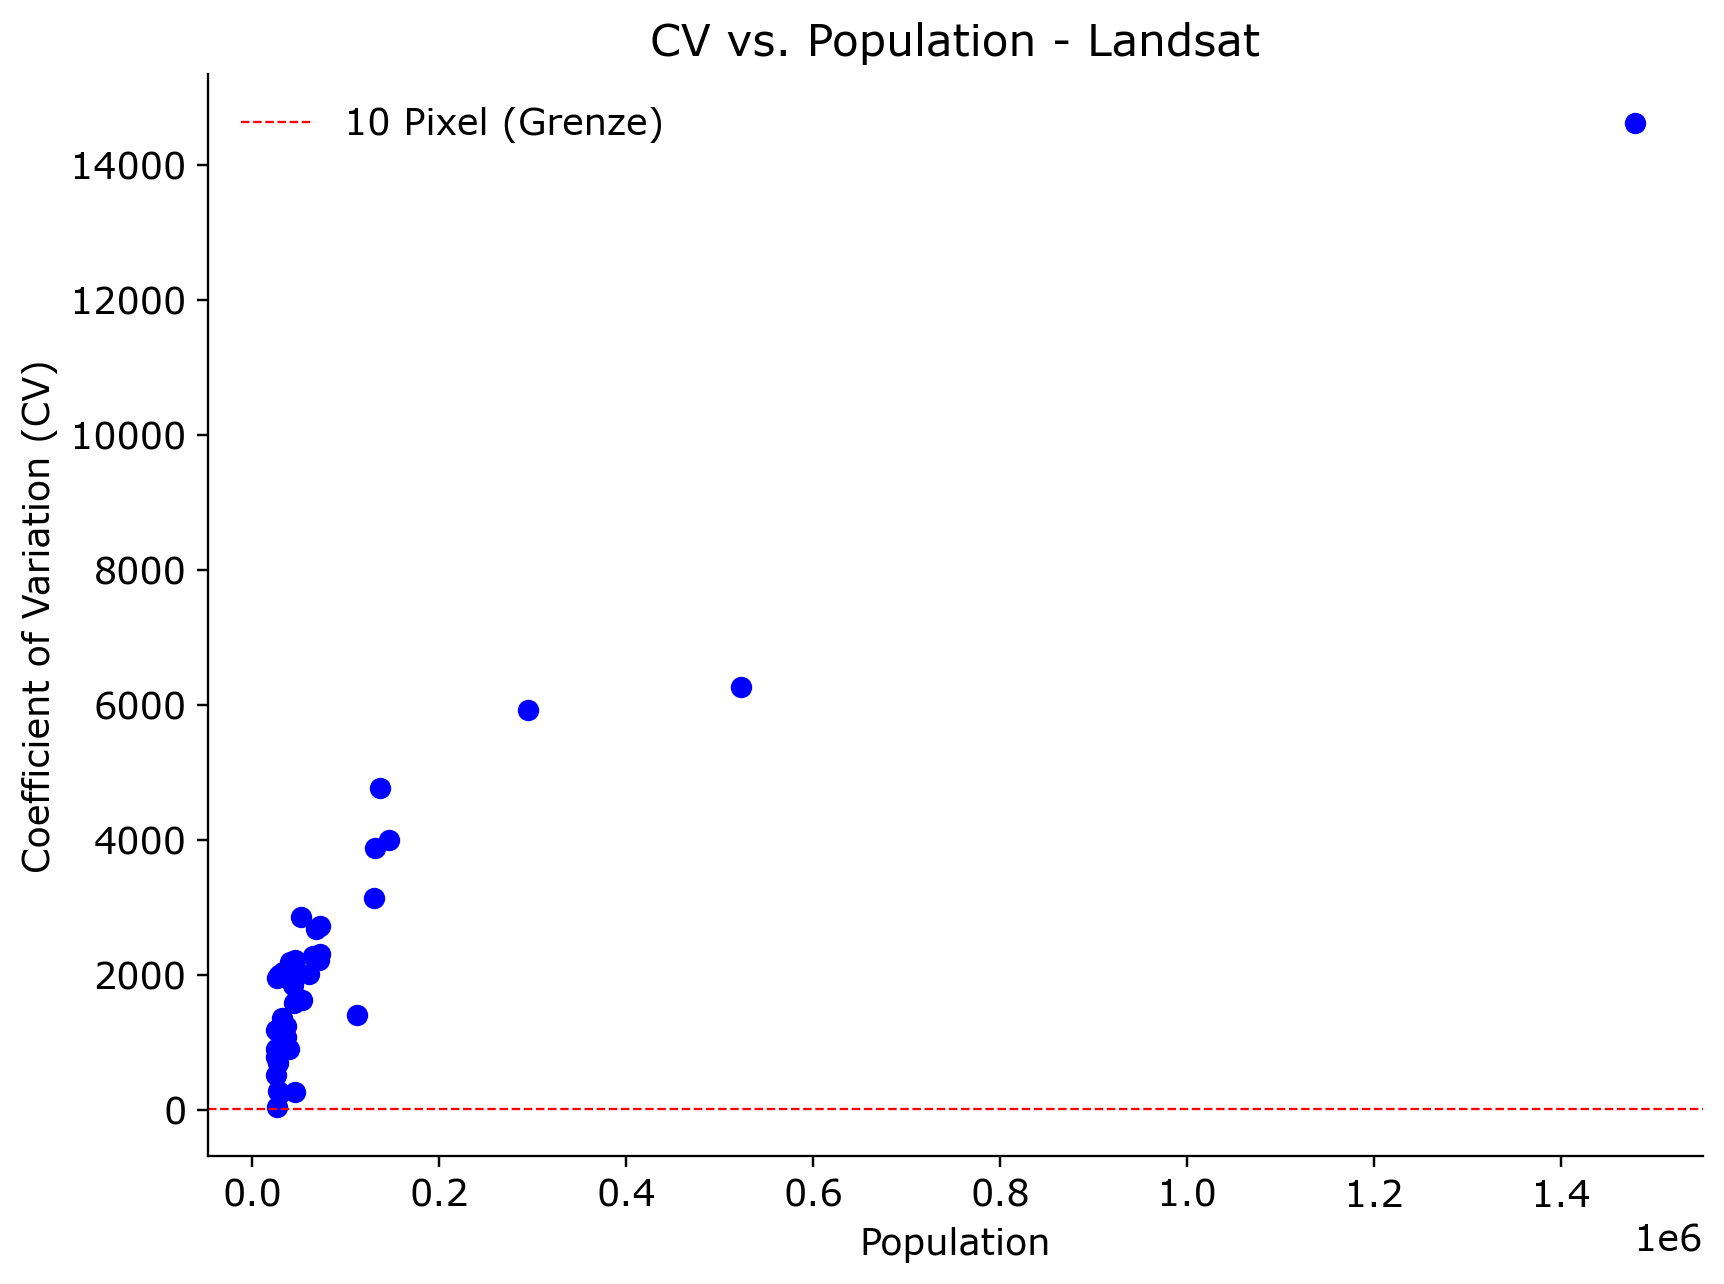

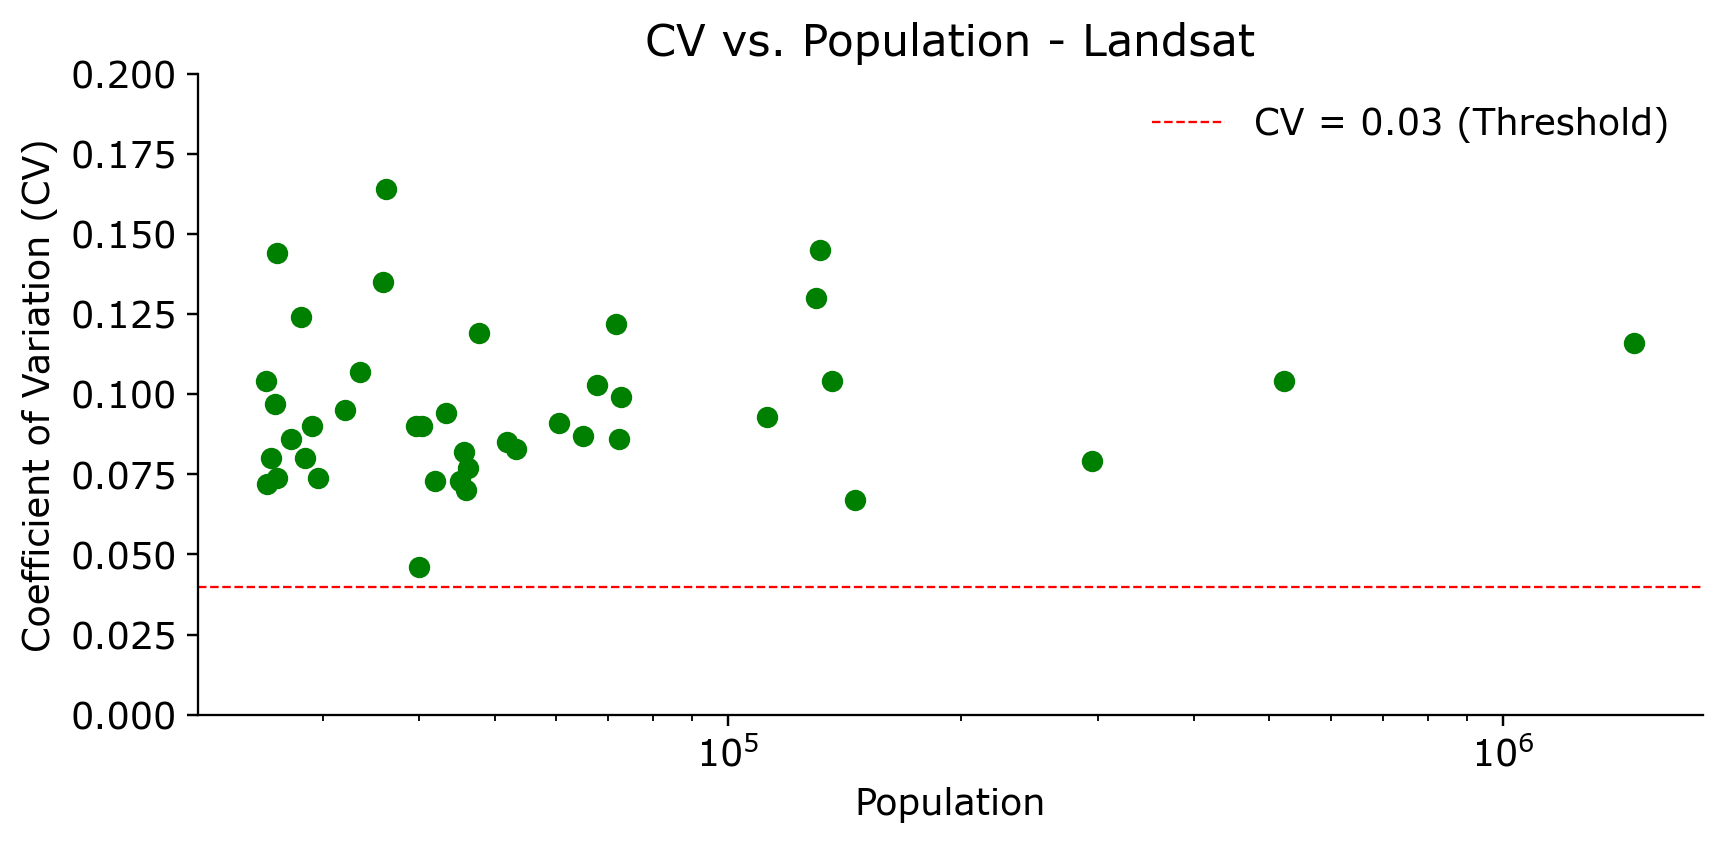

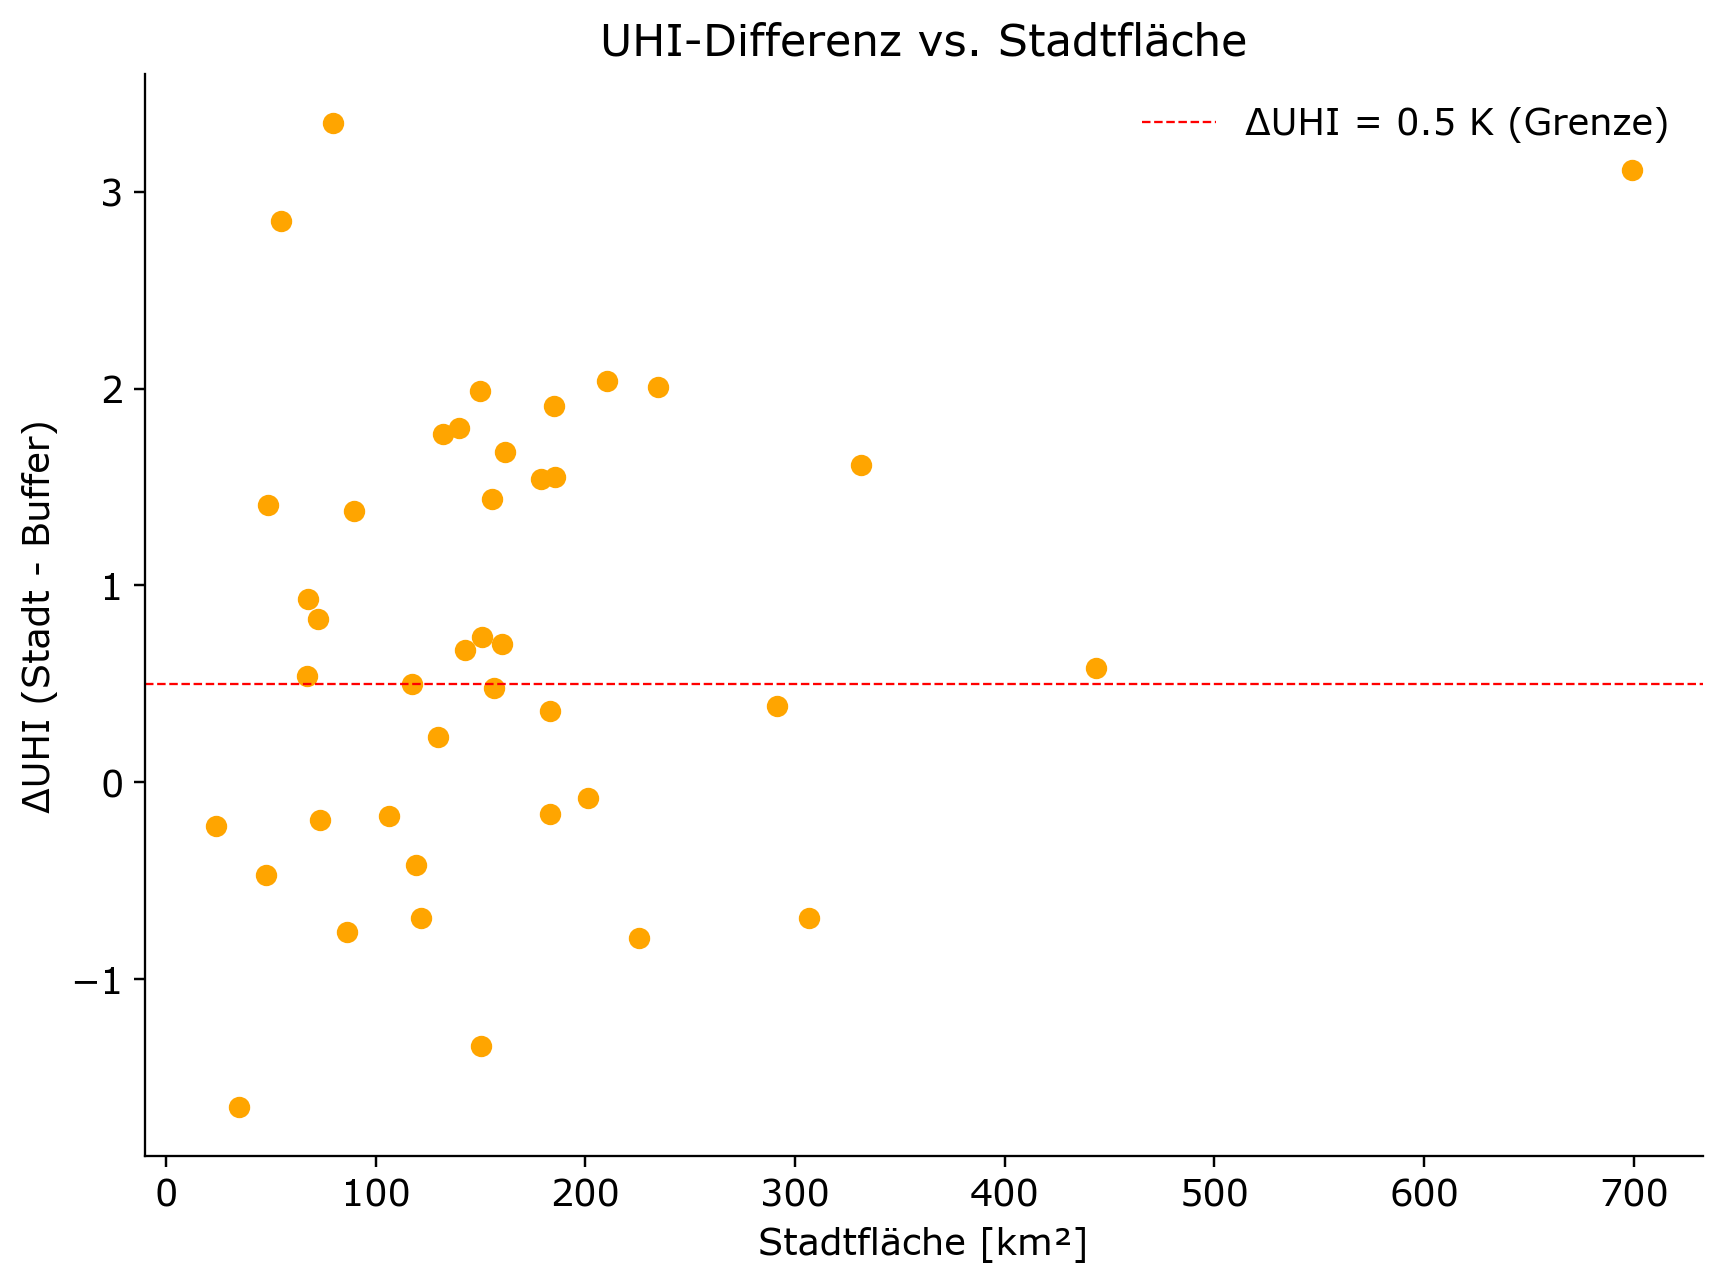

LinregressResult(slope=np.float64(1.480888886906589e-08), intercept=np.float64(0.09438433179570176), rvalue=np.float64(0.14468278911282778), pvalue=np.float64(0.366773490085717), stderr=np.float64(1.6217334714411992e-08), intercept_stderr=np.float64(0.004160536410884776))

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import matplotlib.pyplot as plt

# === 1. Daten laden ===
gdf_cities = gpd.read_file("Input/top50_bayern_staedte.shp").to_crs("EPSG:4326")

df_modis = pd.read_csv("Input/LST_NDVI_Landcover_Landsat_Bayern.csv")
print(df_modis.columns)
df_modis = df_modis.dropna(subset=["Latitude", "Longitude", "LST_Mean", "Buffer_Indicator", "City"])

# GeoDataFrame aus MODIS-Daten
gdf_modis = gpd.GeoDataFrame(
    df_modis,
    geometry=gpd.points_from_xy(df_modis["Longitude"], df_modis["Latitude"]),
    crs="EPSG:4326"
)

# === 2. Stadtfläche berechnen (für Pixeldichte) ===
gdf_cities_metric = gdf_cities.to_crs(epsg=3857)
gdf_cities["Stadtfläche_km2"] = gdf_cities_metric.area / 1e6

# === 3. Analyse pro Stadt ===
results = []

for _, city in gdf_cities.iterrows():
    name = city["Name"]
    einwohner = city["Einwohner"]
    flaeche_km2 = city["Stadtfläche_km2"]

    # Stadtpixel (Buffer == 0)
    urban_pixels = gdf_modis[
        (gdf_modis["City"].str.lower() == name.lower()) & (gdf_modis["Buffer_Indicator"] == 0)
    ]
    pixel_count = len(urban_pixels)

    if pixel_count == 0:
        continue

    lst_mean = urban_pixels["LST_Mean"].mean()
    lst_std = urban_pixels["LST_Mean"].std()
    cv = lst_std / lst_mean if lst_mean else 0
    snr = abs(lst_mean) / 0.5
    pixeldichte = pixel_count / flaeche_km2 if flaeche_km2 else 0

    # Pufferpixel (Buffer == 1)
    rural_pixels = gdf_modis[
        (gdf_modis["City"].str.lower() == name.lower()) & (gdf_modis["Buffer_Indicator"] == 1)
    ]
    delta_uhi = None
    if not rural_pixels.empty:
        rural_mean = rural_pixels["LST_Mean"].mean()
        delta_uhi = lst_mean - rural_mean

    results.append({
        "Stadt": name,
        "Einwohner": einwohner,
        "Stadtfläche_km2": round(flaeche_km2, 2),
        "Pixelanzahl": pixel_count,
        "Pixeldichte": round(pixeldichte, 2),
        "LST_Mean": round(lst_mean, 2),
        "LST_Std": round(lst_std, 2),
        "CV": round(cv, 3),
        "SNR": round(snr, 2),
        "Delta_UHI": round(delta_uhi, 2) if delta_uhi is not None else None,
        "MODIS_geeignet": (
            pixel_count >= 10 and
            cv >= 0.04 and
            delta_uhi is not None and
            delta_uhi >= 0.5
        )
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values("Einwohner", ascending=False)

# === 4. Ergebnisse anzeigen und speichern ===
print(df_results[["Stadt", "Einwohner", "Pixelanzahl", "CV", "Delta_UHI", "MODIS_geeignet"]].to_string(index=False))


# === 5. Plots erzeugen & speichern ===
plt.style.use("FST.mplstyle")
fig_dir = "modis_plots"
os.makedirs(fig_dir, exist_ok=True)

# Plot 1: Pixelanzahl vs. Einwohner
plt.figure(figsize=(8, 6))
plt.scatter(df_results["Einwohner"], df_results["Pixelanzahl"], c="blue")
plt.axhline(10, color="red", linestyle="--", label="10 Pixel (Grenze)")
plt.xlabel("Population")
plt.ylabel("Coefficient of Variation (CV)")
plt.title("CV vs. Population - Landsat")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "plot_pixelanzahl_vs_einwohner.png"))
plt.show()

# Plot 2: CV vs. Einwohner
plt.figure(figsize=(8, 4))
plt.scatter(df_results["Einwohner"], df_results["CV"], c="green")
plt.axhline(0.04, color="red", linestyle="--", label="CV = 0.03 (Threshold)")
plt.xlabel("Population")
plt.ylabel("Coefficient of Variation (CV)")
plt.title("CV vs. Population - Landsat")
plt.ylim([0,0.2])
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "plot_cv_vs_einwohner.png"))
plt.show()



# Plot 3: ΔUHI vs. Stadtfläche
plt.figure(figsize=(8, 6))
plt.scatter(df_results["Stadtfläche_km2"], df_results["Delta_UHI"], c="orange")
plt.axhline(0.5, color="red", linestyle="--", label="ΔUHI = 0.5 K (Grenze)")
plt.xlabel("Stadtfläche [km²]")
plt.ylabel("ΔUHI (Stadt - Buffer)")
plt.title("UHI-Differenz vs. Stadtfläche")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "plot_deltaUHI_vs_flaeche.png"))
plt.show()


from scipy.stats import linregress

linregress(df_results["Einwohner"], df_results["CV"])


Bad key mpl_toolkits.legacy_colorbar in file FST.mplstyle, line 757 ('mpl_toolkits.legacy_colorbar: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/2247027077.py:4: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/2247027077.py:4: UserWarning: Style includes a parameter, 'backend_fallback', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_15856/2247027077.py:4: UserWarning: Style includes a parameter, 'date.epoch', that is not related to style.  Ignoring this parameter.
  plt.style.use("FST.mplstyle")
/var/folders/p0/6j2q4p

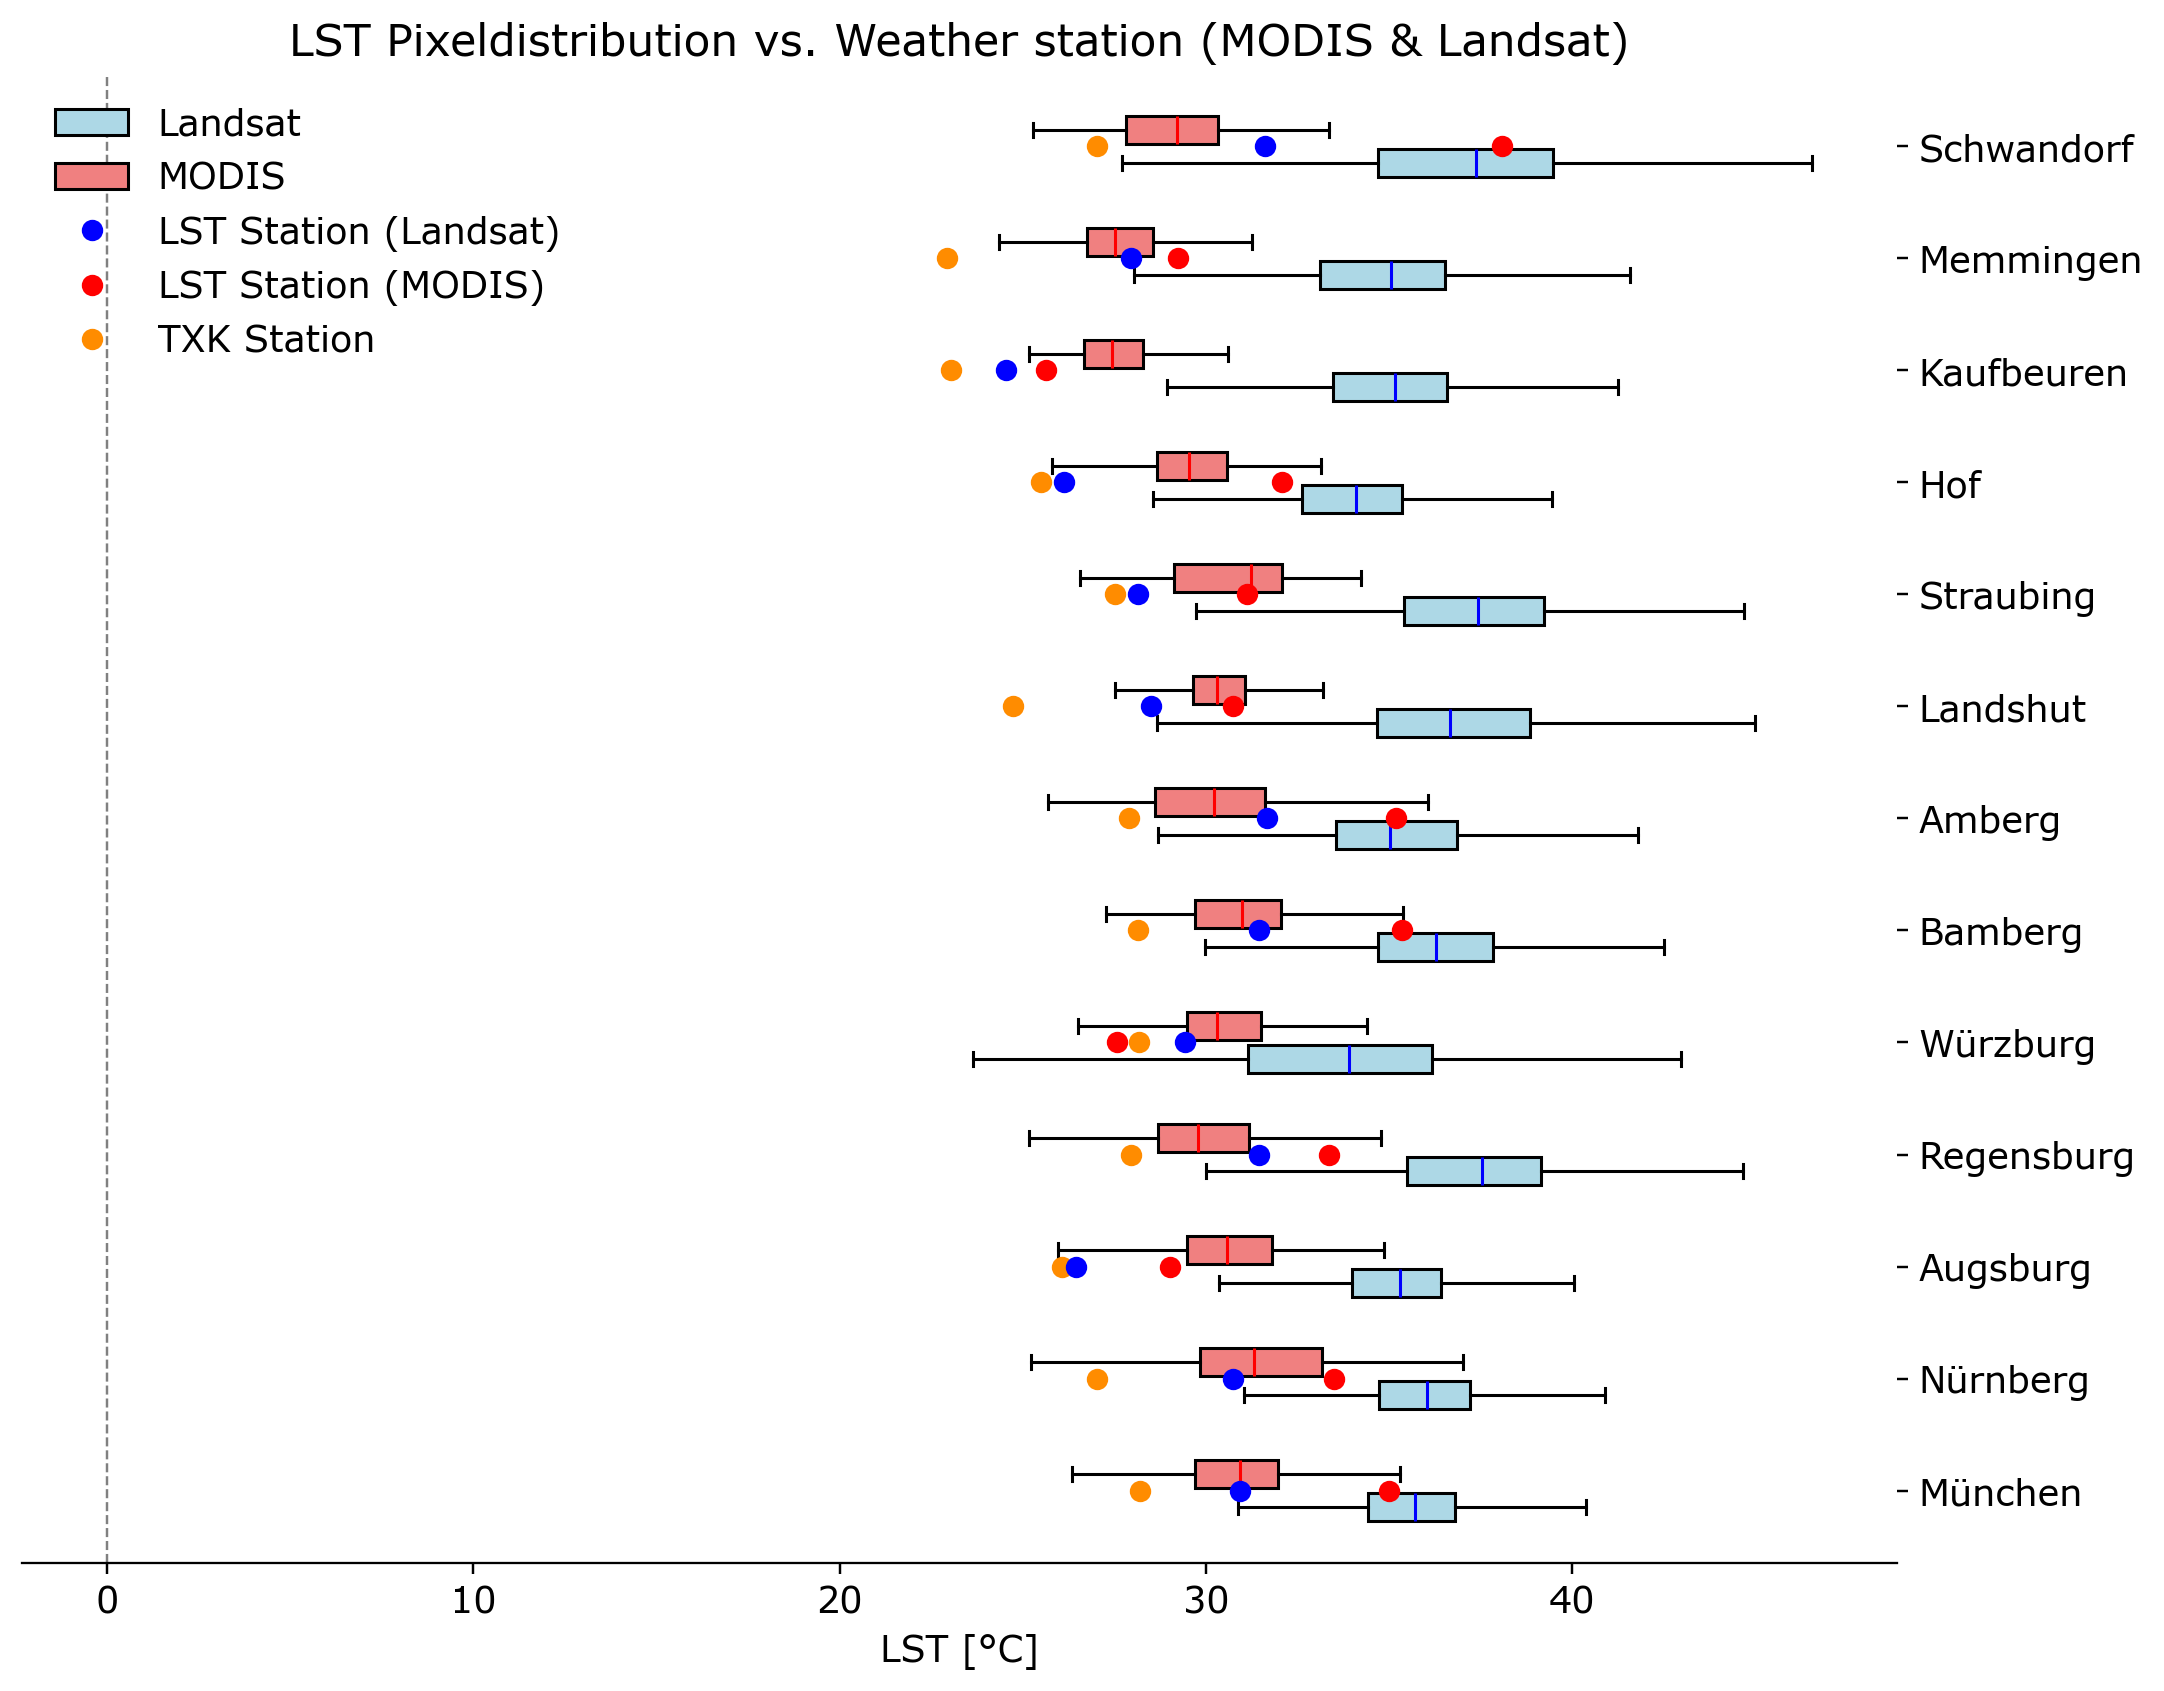

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("FST.mplstyle")

# === 1. Daten einlesen ===
stations_df = pd.read_csv("Input/city_metrics.csv")
landsat_df = pd.read_csv("Input/LST_NDVI_Landcover_Landsat_Bayern.csv")
modis_df = pd.read_csv("Input/LST_all_NDVI_Landcover_Modis_Bayern.csv")
city_size_df = pd.read_excel("Input/Biggest_Cities_Bavaria.xlsx")

# === 2. Spalten vereinheitlichen ===
city_size_df = city_size_df.rename(columns={
    "Name": "City",         # ggf. anpassen
    "Einwohner": "Population"  # ggf. anpassen
})
modis_df = modis_df.rename(columns={"LST_day_Max": "LST_max"})
modis_df["sensor"] = "MODIS"
modis_df["LST_max"] = pd.to_numeric(modis_df["LST_max"], errors="coerce")

landsat_df = landsat_df.rename(columns={"LST_Max": "LST_max"})
landsat_df["sensor"] = "Landsat"

pixels_df = pd.concat([landsat_df, modis_df], ignore_index=True)

# === 3. Wetterstationsdaten (Sommer, MODIS & Landsat) ===
stations_df = stations_df[stations_df["season"] == "Summer"]

# === 4. Städte sammeln ===
unique_cities = pixels_df["City"].dropna().unique()

records = []

for city in unique_cities:
    pix = pixels_df[pixels_df["City"].str.contains(city, case=False, na=False)]
    stn_landsat = stations_df[
        (stations_df["Name"].str.contains(city, case=False, na=False)) &
        (stations_df["sensor"] == "Landsat")
    ]
    stn_modis = stations_df[
        (stations_df["Name"].str.contains(city, case=False, na=False)) &
        (stations_df["sensor"] == "MODIS")
    ]

    if pix.empty or (stn_landsat.empty and stn_modis.empty):
        continue

    ls_vals = pix[pix["sensor"] == "Landsat"]["LST_max"].dropna()
    md_vals = pix[pix["sensor"] == "MODIS"]["LST_max"].dropna()

    if len(ls_vals) + len(md_vals) == 0:
        continue

    lst_stat_landsat = stn_landsat["LST"].mean() if not stn_landsat.empty else np.nan
    lst_stat_modis   = stn_modis["LST"].mean() if not stn_modis.empty else np.nan
    txk_stat         = stn_landsat["TXK"].mean() if not stn_landsat.empty else np.nan

    # Einwohnerzahl suchen
    matching_city = city_size_df[city_size_df["City"].str.contains(city, case=False, na=False)]
    population = matching_city["Population"].values[0] if not matching_city.empty else np.nan

    records.append({
        "City": city,
        "Landsat": ls_vals,
        "MODIS": md_vals,
        "LST_station_landsat": lst_stat_landsat,
        "LST_station_modis": lst_stat_modis,
        "TXK_station": txk_stat,
        "Population": population
    })

# === 5. Sortieren nach Bevölkerung ===
records = sorted(records, key=lambda x: (np.isnan(x["Population"]), -x["Population"] if not np.isnan(x["Population"]) else 0))

# === 6. Plot-Daten vorbereiten ===
order = [r["City"] for r in records]
data_ls_all = [r["Landsat"] for r in records]
data_md_all = [r["MODIS"] for r in records]
lst_landsat_pts = [r["LST_station_landsat"] for r in records]
lst_modis_pts = [r["LST_station_modis"] for r in records]
txk_pts = [r["TXK_station"] for r in records]

# === 7. Plot erstellen ===
y = np.arange(len(order))
offset = 0.15
fig, ax = plt.subplots(figsize=(10, len(order)*0.45 + 2))

# Boxplots
bp_ls = ax.boxplot(
    data_ls_all, positions=y - offset, vert=False, widths=0.25,
    patch_artist=True, showfliers=False,
    boxprops=dict(facecolor="lightblue"), medianprops=dict(color="blue")
)
bp_md = ax.boxplot(
    data_md_all, positions=y + offset, vert=False, widths=0.25,
    patch_artist=True, showfliers=False,
    boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="red")
)

# Wetterstationspunkte
ax.scatter(lst_landsat_pts, y, color="red", label="LST Station (Landsat)", zorder=10)
ax.scatter(lst_modis_pts, y, color="darkorange", label="LST Station (MODIS)", zorder=11)
ax.scatter(txk_pts, y, color="blue", label="TXK Station", zorder=12)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.spines["left"].set_visible(False)

# Achsen & Layout
ax.set_yticks(y)
ax.set_yticklabels(order)
ax.axvline(0, color="grey", linestyle="--", linewidth=0.8)
ax.set_xlabel("LST [°C]")
ax.set_title("LST Pixeldistribution vs. Weather station (MODIS & Landsat)")

# Legende
ax.legend(
    [bp_ls["boxes"][0], bp_md["boxes"][0],
     plt.Line2D([], [], color="blue", marker="o", linestyle="None"),
     plt.Line2D([], [], color="red", marker="o", linestyle="None"),
     plt.Line2D([], [], color="darkorange", marker="o", linestyle="None")],
    ["Landsat", "MODIS", "LST Station (Landsat)", "LST Station (MODIS)", "TXK Station"],
    loc="upper left"
)

plt.tight_layout()
plt.show()


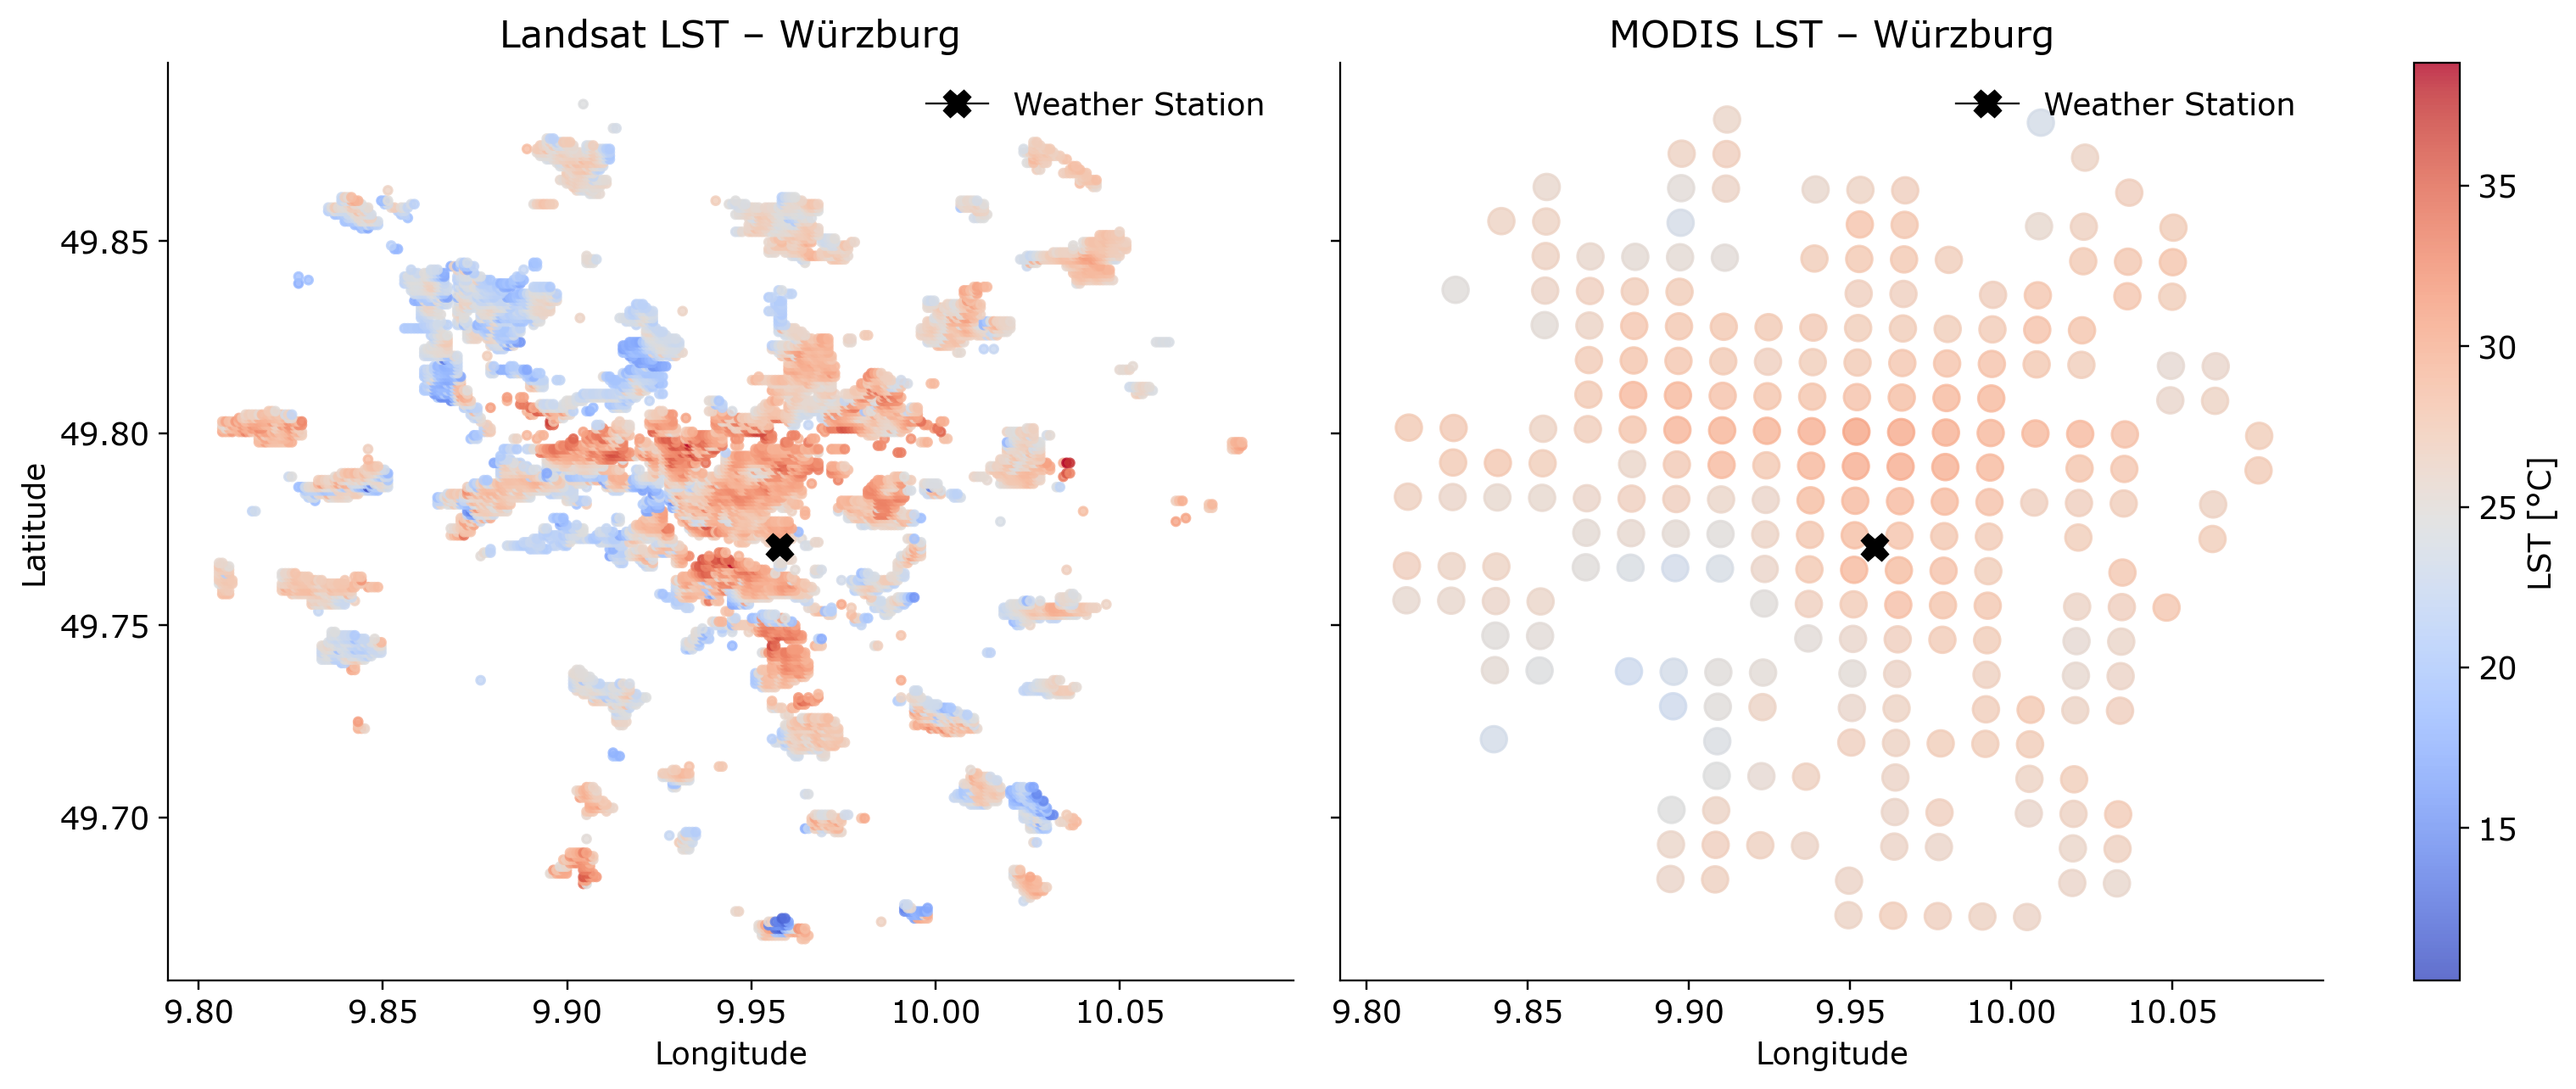

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
stations_df = pd.read_csv("Input/city_metrics.csv")
landsat_df = pd.read_csv("Input/LST_NDVI_Landcover_Landsat_Bayern.csv")
modis_df = pd.read_csv("Input/LST_all_NDVI_Landcover_Modis_Bayern.csv")

# === 2. Rename LST columns ===
landsat_df = landsat_df.rename(columns={"LST_Mean": "LST_mean"})
modis_df = modis_df.rename(columns={"LST_day_Mean": "LST_mean"})

# === 3. Filter for Würzburg ===
landsat_wue = landsat_df[landsat_df["City"].str.contains("Würzburg", case=False, na=False)]
modis_wue = modis_df[modis_df["City"].str.contains("Würzburg", case=False, na=False)]
station_wue = stations_df[stations_df["Name"].str.contains("Würzburg", case=False, na=False)]

# === 4. Check data ===
if landsat_wue.empty and modis_wue.empty:
    raise ValueError("No Landsat or MODIS data found for Würzburg.")
if station_wue.empty:
    raise ValueError("No weather station found for Würzburg.")

# === 5. Station coordinates ===
station_lat = station_wue["Breite"].values[0]
station_lon = station_wue["Laenge"].values[0]

# === 6. Shared color scale ===
combined_lst = pd.concat([landsat_wue["LST_mean"], modis_wue["LST_mean"]], ignore_index=True)
vmin = combined_lst.min()
vmax = combined_lst.max()
cmap = "coolwarm"

# === 7. Create side-by-side plots ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Landsat
sc1 = ax1.scatter(
    landsat_wue["Longitude"], landsat_wue["Latitude"],
    c=landsat_wue["LST_mean"], cmap=cmap, s=10, alpha=0.8,
    vmin=vmin, vmax=vmax
)
ax1.plot(station_lon, station_lat, marker="X", color="black", markersize=10, label="Weather Station")
ax1.set_title("Landsat LST – Würzburg")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.legend(loc="upper right")

# MODIS
sc2 = ax2.scatter(
    modis_wue["Longitude"], modis_wue["Latitude"],
    c=modis_wue["LST_mean"], cmap=cmap, s=100, alpha=0.8,
    vmin=vmin, vmax=vmax
)
ax2.plot(station_lon, station_lat, marker="X", color="black", markersize=10, label="Weather Station")
ax2.set_title("MODIS LST – Würzburg")
ax2.set_xlabel("Longitude")
ax2.legend(loc="upper right")

# Colorbar outside right plot
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.08)
cbar.set_label("LST [°C]")

plt.tight_layout()
plt.show()
